# Intel Image Classification using CNN

## Define the problem 
### What is the input data
- For this project, I utilized the Intel Image dataset. The dataset can be accessed through the following link: [Intel Image Dataset](https://www.kaggle.com/datasets/puneet6060/intel-image-classification). This dataset comprises multiple images in JPG format, which are to be processed to serve as input for our deep learning model.

### What type of problem 
- The problem is multilabel classification task. Within the dataset, each image is associated with one of six distinct labels: 'buildings', 'forest', 'glacier', 'mountain', 'sea', and 'street'. The objective is to develop a model capable of accurately identifying the labels associated with each image.

### What are you hoping to predict 
- The goal is to predict the appropriate labels for the images. 

## Choosing measure of success 
To evaluate the model's success, I'll consider four key metrics: Accuracy, Precision, Recall and ROC AUC. 

Since this is a data set with multiple labels, for a more meaningful evaluation I would use categorical accuracy over overall acuracy. It evaluate each label independently, providing insight into how effectively the model predicts each category.
Precision measures the proportion of correctly predicted positive cases out of all predicted positive cases and provides insight into the model's ability to avoid false positives.
Recall measures the proportion of correctly predicted positive cases out of all positive cases and indicates the model's ability to capture all positive instances.
ROC AUC measures the model's ability to effectively distinguish between classes.
These four metrics would show clearly the performance of the model very clearly. 

## Deciding on an evaluation protocol 
For the evaluation protocol, I will use a hold-out validation approach. 

This involves splitting the dataset into training and validation sets. The model will be trained on the training set and then evaluated on the validation set to assess its performance. Additionally, grid search will be combined to this process to try various hyperparameters and find the optimal hyperparameters for the model.

In [1]:
# Necessary libraries
import os
import keras 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import tensorflow as tf 
import itertools
import seaborn as sns

from glob import glob
from PIL import Image
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.utils import shuffle 
from sklearn.model_selection import train_test_split
from keras.models import Sequential  
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import KFold

## Loading the dataset 

The dataset is structured with folders representing different classes, each containing corresponding images. To load the data, each folder in the directory is iterated through, the images (with the .jpg extension) are read, converted to RGB format, and resized to a predefined size of 150x150 pixels. Finally, the image data and corresponding labels are stored separately in arrays.

In [2]:
# directories to train and test set
folder_urls = ['../ML_FINAL_TERM/intel_dataset/seg_train/seg_train','../ML_FINAL_TERM/intel_dataset/seg_test/seg_test']

In [3]:
image_size = (150, 150)
my_seed=42

def load_dataset(data_dir):
    """
    Load images and their corresponding labels from folder name 

    parameters:
    data_dir: directory to the dataset 

    returns: 
            two arrays: 
           - X_images: an array of image data
           - y_labels: an array of corresponding labels
    """
    X_images = []
    y_labels = []

    for folder in os.listdir(data_dir):
        folder_path = os.path.join(data_dir, folder)

        for filename in glob(os.path.join(folder_path, '*.jpg')):
            img_path = filename
            image = Image.open(img_path)
            image = image.convert('RGB')
            image = image.resize(image_size)  
            X_images.append(np.array(image))
            y_labels.append(folder)

    return np.array(X_images), np.array(y_labels)

In [4]:
X_image_train, y_label_train= load_dataset(folder_urls[0])
train_images, train_labels = shuffle(X_image_train, y_label_train, random_state=my_seed)

In [5]:
X_image_test, y_label_test= load_dataset(folder_urls[1])
test_images, test_labels = shuffle(X_image_test, y_label_test, random_state=my_seed)

In [6]:
# train set further divided to validation and train set 
X_image_train,X_image_val,y_label_train, y_label_val = train_test_split(X_image_train,y_label_train,
                                                                        test_size=0.25,
                                                                        shuffle=True,
                                                                        stratify=y_label_train,
                                                                        random_state=my_seed)

The training set contains 10,525 instances, the validation set consists of 3,509 instances, and the test set comprises 3,000 instances.

In [7]:
print('Train Images Shape:      ', X_image_train.shape)
print('Train Labels Shape:      ', y_label_train.shape)

print('\nValidation Images Shape: ', X_image_val.shape)
print('Validation Labels Shape: ', y_label_val.shape)

print('\nTest Images Shape:       ', X_image_test.shape)
print('Test Labels Shape:       ', y_label_test.shape)

Train Images Shape:       (10525, 150, 150, 3)
Train Labels Shape:       (10525,)

Validation Images Shape:  (3509, 150, 150, 3)
Validation Labels Shape:  (3509,)

Test Images Shape:        (3000, 150, 150, 3)
Test Labels Shape:        (3000,)


## Explore the dataset

The dataset include six different labels . 

In [8]:
total_labels = np.unique(y_label_test)
print(total_labels)

['buildings' 'forest' 'glacier' 'mountain' 'sea' 'street']


### Class Distribution

In [9]:
def plot_class_distribution(y_train, class_names):
    """
    ploot the class distribution of the training set

    parameters:
    y_train     : labels of the training set.
    class_names : list of unique class labels

    returns: -
    display the bar chart and pie chart
    """
    train_counts = pd.Series(y_train).value_counts().reindex(class_names, fill_value=0)
    colors = ['#3F75A8','#9DC639','#94ECF4','#485838','#3F89E7','#7C7C7C']
    
    ax = train_counts.plot(kind='bar', figsize=(8, 5), color=colors)
    plt.title('Class Distribution in Training Set')
    plt.xlabel('Class')
    plt.ylabel('Count')
    
    for p in ax.patches:
        ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height() * 1.01),
                    ha='center', va='bottom')
    
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.pie(train_counts, labels=train_counts.index, autopct='%1.1f%%', colors=colors, explode=[0.05] * len(train_counts))
    ax.set_title('Class Distribution in Training Set')
    
    plt.show()

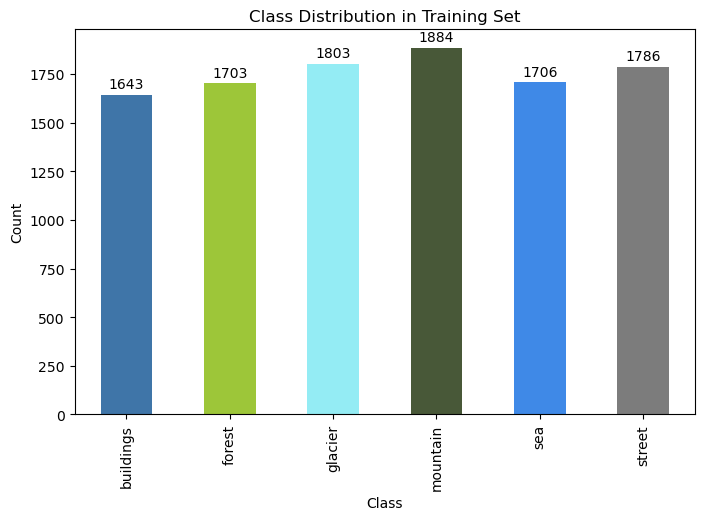

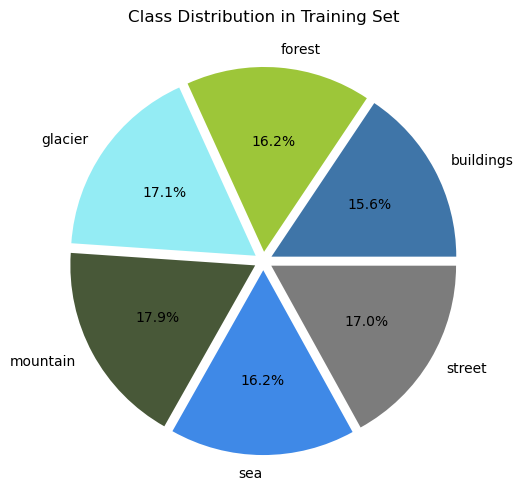

In [10]:
plot_class_distribution(y_label_train,total_labels)

The dataset shows a good balance across all six labels, with each label approximately 15% to 18% of the total. Especially, no single  class outweighs the other classes , so there is no need to adjust the balance of the dataset.

In [11]:
def display_images_by_class(x_train, y_train, classes):
    """
    show sample images for each class in the dataset

    parameters:
    x_train : array containing the training images
    y_train : array containing the labels of the images
    classes : list of unique class labels

    returns: -
    display the sample images
    """
    num_classes = len(classes)
    for cls in classes: 
        class_indices = np.where(y_train == cls)[0][:5]
        
        print(f"Displaying images for Label: {cls}")
        fig, axes = plt.subplots(1, 5, figsize=(15, 3))
        fig.suptitle(f"Label: {cls}")
        
        for i, index in enumerate(class_indices):
            axes[i].imshow(x_train[index])
            axes[i].axis('off')
        
        plt.show()

Displaying images for Label: buildings


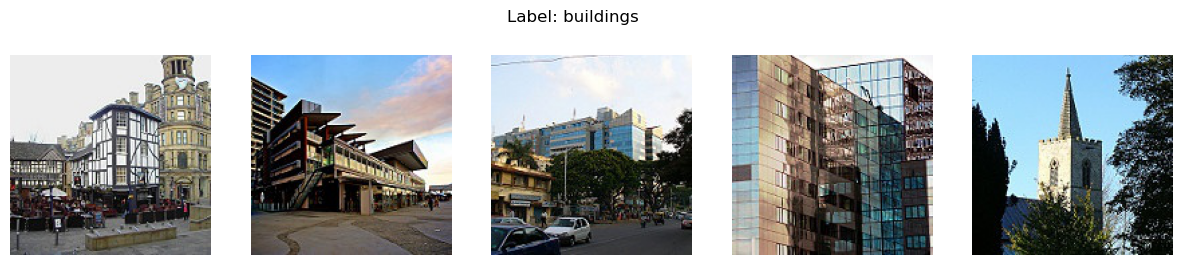

Displaying images for Label: forest


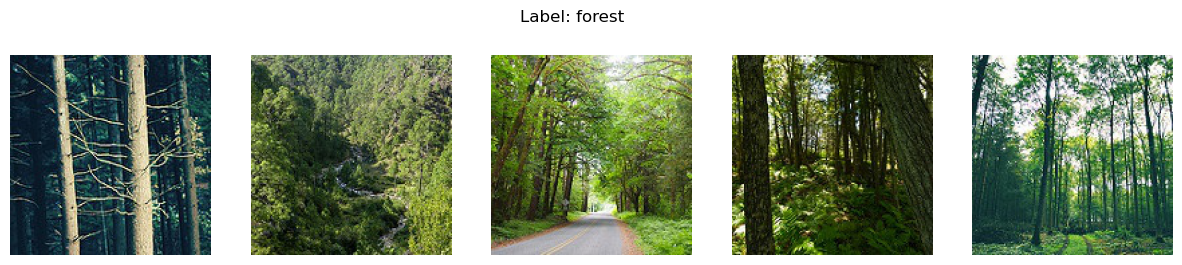

Displaying images for Label: glacier


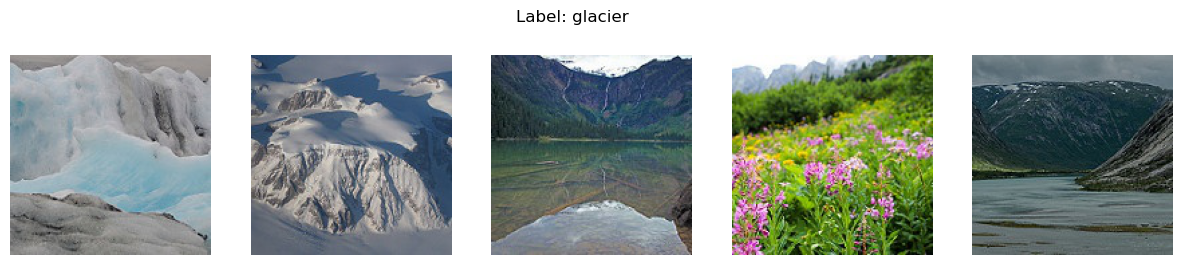

Displaying images for Label: mountain


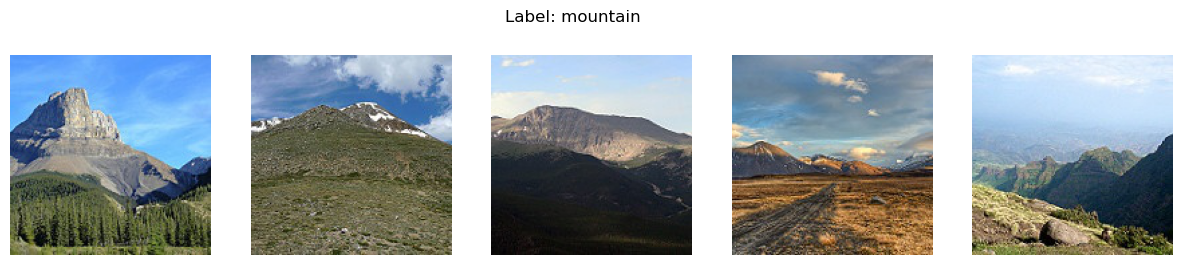

Displaying images for Label: sea


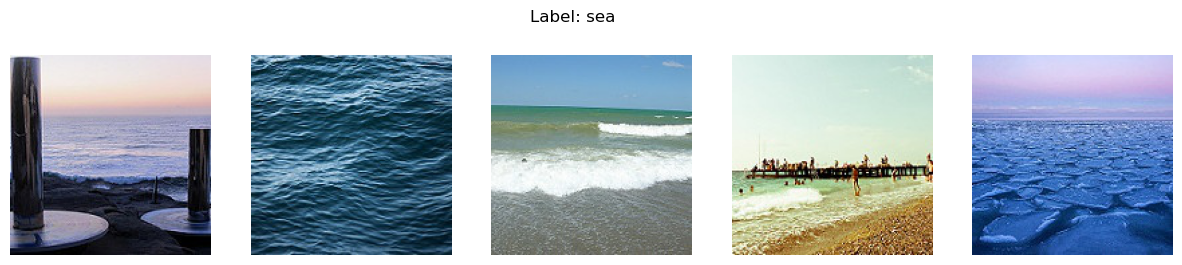

Displaying images for Label: street


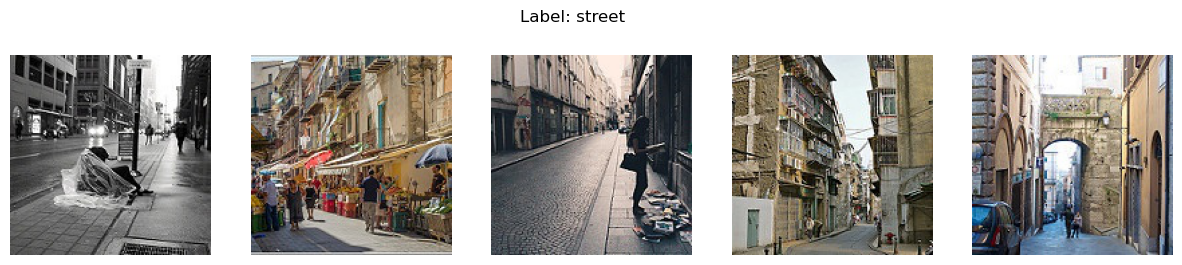

In [12]:
display_images_by_class(X_image_train,y_label_train,total_labels)

## Preparing you data  

In the preprocessing stage, three key processes are undertaken. Initially, the image data undergo flattening, transforming image data from their original 3D format into a 1D array. This is followed by applying the Min-Max scaling technique to standardize the feature values across the image data, constraining them within a defined range of 0 to 1. Finally, the categorical class labels are one-hot encoded, converting them into binary vectors, which ensures compatibility with classification algorithms.

In [13]:
# Flatten images
X_image_train_flattened = X_image_train.reshape(X_image_train.shape[0], -1)
X_image_val_flattened = X_image_val.reshape(X_image_val.shape[0], -1)
X_image_test_flattened = X_image_test.reshape(X_image_test.shape[0], -1)
print('Shape before flattening: ',X_image_train[0].shape)
print('Shape after flattening: ',X_image_train_flattened[0].shape)

# Min-Max scaling
scaler = preprocessing.MinMaxScaler()

X_train = scaler.fit_transform(X_image_train_flattened)
X_val= scaler.transform(X_image_val_flattened)
X_test = scaler.transform(X_image_test_flattened)
print('Before scaling: ',X_image_train_flattened[0])
print('After scaling: ',X_train[0])

Shape before flattening:  (150, 150, 3)
Shape after flattening:  (67500,)
Before scaling:  [150 146 143 ... 114 119 122]
After scaling:  [0.58823529 0.57254902 0.56078431 ... 0.44705882 0.46666667 0.47843137]


In [14]:
# one-hot encoding 
onehot_encoder = OneHotEncoder(sparse_output=False)
y_train= onehot_encoder.fit_transform(y_label_train.reshape(-1, 1))
y_val= onehot_encoder.transform(y_label_val.reshape(-1, 1))
y_test= onehot_encoder.transform(y_label_test.reshape(-1, 1))
print('Before one hot encoding: ', y_label_train[0])
print('After one hot encoding : ', y_train[0])

Before one hot encoding:  glacier
After one hot encoding :  [0. 0. 1. 0. 0. 0.]


## Setting baseline

The baseline is set using majority class baseline 

In [15]:
label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(y_label_train)
all_labels = np.concatenate((y_label_train,y_label_val,y_label_test))
encoded_labels = label_encoder.transform(all_labels) 

class_counts= np.bincount(encoded_labels)
most_common_class = np.argmax(class_counts)

classes=[0,1,2,3,4,5]
counts = pd.DataFrame({'Class': classes, 'Counts': class_counts})
display(counts)

print('Most common class: ', most_common_class, '(Mountains)')

Class  Counts
0      0    2628
1      1    2745
2      2    2957
3      3    3037
4      4    2784
5      5    2883

Most common class:  3 (Mountains)


The baseline is set as accuracy of 17.83%.  

In [16]:
# Baseline accuracy 
print(f'Accuracy: {(class_counts[3] / len(all_labels) * 100):.2f}%')

Accuracy: 17.83%


## Developing a model that does better than a baseline

In [15]:
def set_up_dnn_model(hidden_layers=0,neurons=None,
                     activation=None,dropout=None,
                     input_dimension=None, 
                     output_dimension=None,
                     metrics=['accuracy'],
                     name=None):
    """
    Creates a DNN model with specified architecture and parameters

    parameters:
    hidden_layers   (int): number of hidden layers in the model
    neurons         (int): number of neurons in each hidden layer
    activation      (str): activation function to use in hidden layers
    dropout       (float): dropout rate to apply in hidden layers
    input_dimension (int): dimensionality of the input data
    output_dimension(int): dimensionality of the output data
    metrics        (list): liist of metrics
    name            (str): name for the model(optional)

    returns: Compiled DNN model
    """
    
    model = Sequential()
    if hidden_layers > 0:
        for layer in range(hidden_layers):
            if neurons is not None:
                model.add(Dense(neurons, activation=activation, input_shape=(input_dimension,)))
            if dropout is not None:
                model.add(Dropout(dropout))
        
    model.add(Dense(output_dimension, activation='softmax', input_shape=(input_dimension,)))
  
    if name is not None:
        model._name = name

    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=metrics)
    
    return model

In [16]:
def train_dnn(model, train_X, train_y,
                      val_X, val_y, 
                      batch_size=32, epochs=50, 
                      callbacks=[]) :
    """
    Trains the DNN model

    parameters:
    model    (Sequential): DNN model to train
    train_X  (array): training data
    train_y  (array): labels of the training data
    val_X    (array): validation data
    val_y    (array): labels of the validation data
    batch_size (int): number of samples per gradient update
    epochs     (int): number of epochs 
    callbacks (list): callbacks to apply during training (optional)

    returns:
    dict: a dictionary containing the trained model, validation score, and training history
    """
    history = model.fit(train_X, train_y,
                        batch_size=batch_size,
                        epochs=epochs, 
                        validation_data=(val_X, val_y),
                        callbacks=callbacks,
                        verbose=0)

    return {'model': model, 'history': history }

In [17]:
def plot_training(history):
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))

    loss_ax = axes[0]
    accuracy_ax = axes[1]

    loss_ax.plot(history['loss'], label='Train Loss')
    loss_ax.plot(history['val_loss'], label='Validation Loss')
    loss_ax.set_title('Model Loss')
    loss_ax.set_ylabel('Loss')
    loss_ax.set_xlabel('Epoch')
    loss_ax.legend()

    accuracy_ax.plot(history['categorical_accuracy'], label='Train Accuracy')
    accuracy_ax.plot(history['val_categorical_accuracy'], label='Validation Accuracy')
    accuracy_ax.set_title('Model Accuracy')
    accuracy_ax.set_ylabel('Accuracy')
    accuracy_ax.set_xlabel('Epoch')
    accuracy_ax.legend()

    plt.tight_layout()
    plt.show()

In [18]:
# Defining the four metrics
multi_metrics = ['categorical_accuracy', 
                tf.keras.metrics.Precision(name='precision'),
                tf.keras.metrics.Recall(name='recall'),
                tf.keras.metrics.AUC(name='AUC', multi_label=True)]

early_stopping = EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=10, verbose=1)

input_dim = X_train.shape[1]
output_class = y_train.shape[1]
print('Input dimension: ', input_dim, '\nOutput dimension: ',output_class)

2024-03-10 14:02:17.136551: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-03-10 14:02:17.140189: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-03-10 14:02:17.140214: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-03-10 14:02:17.146109: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-10 14:02:17.151527: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Input dimension:  67500 
Output dimension:  6


#### Meeting Assumptions
The goal of developing a model that outperforms the baseline is to ensure that two assumptions are met. 
- The first assumption is that the model can accurately predict the class of the given input data (image data).
- Second assuption is that the available data provides sufficient information for the model to learn the relationship between the input data and its class.

These assumptions were indeed met, as the small model built was able to beat the baseline accuracy, indicating that the model can predict the classes of the given image data and is learning the general trend.

In [30]:
# building small model with only on dense layer 
btb_model = set_up_dnn_model(hidden_layers=1,
                            input_dimension=input_dim,
                            output_dimension=output_class,
                            metrics=multi_metrics,
                            name='Model_better_than_baseline')

In [31]:
btb_model.summary()

Model: "Model_better_than_baseline"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 6)                 405006    
                                                                 
Total params: 405006 (1.54 MB)
Trainable params: 405006 (1.54 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [32]:
trained_btb_model = train_dnn(btb_model,
                              X_train, y_train,
                              X_val, y_val,
                              callbacks=[early_stopping])

Restoring model weights from the end of the best epoch: 4.
Epoch 14: early stopping


In [33]:
evaluate_model = trained_btb_model['model'].evaluate(X_val,y_val,verbose=0)
print(evaluate_model)
print('Accuracy   : {:.2f}% - (beats the baseline accuracy of 17.83%)'.format(evaluate_model[1]*100))
print('Precision  : {:.2f}%'.format(evaluate_model[2]*100))
print('Recall     : {:.2f}%'.format(evaluate_model[3]*100))
print('AUC        : {:.2f}%'.format(evaluate_model[4]*100))

[11.358162879943848, 0.410373330116272, 0.4112096130847931, 0.4098033607006073, 0.6902502775192261]
Accuracy   : 41.04% - (beats the baseline accuracy of 17.83%)
Precision  : 41.12%
Recall     : 40.98%
AUC        : 69.03%


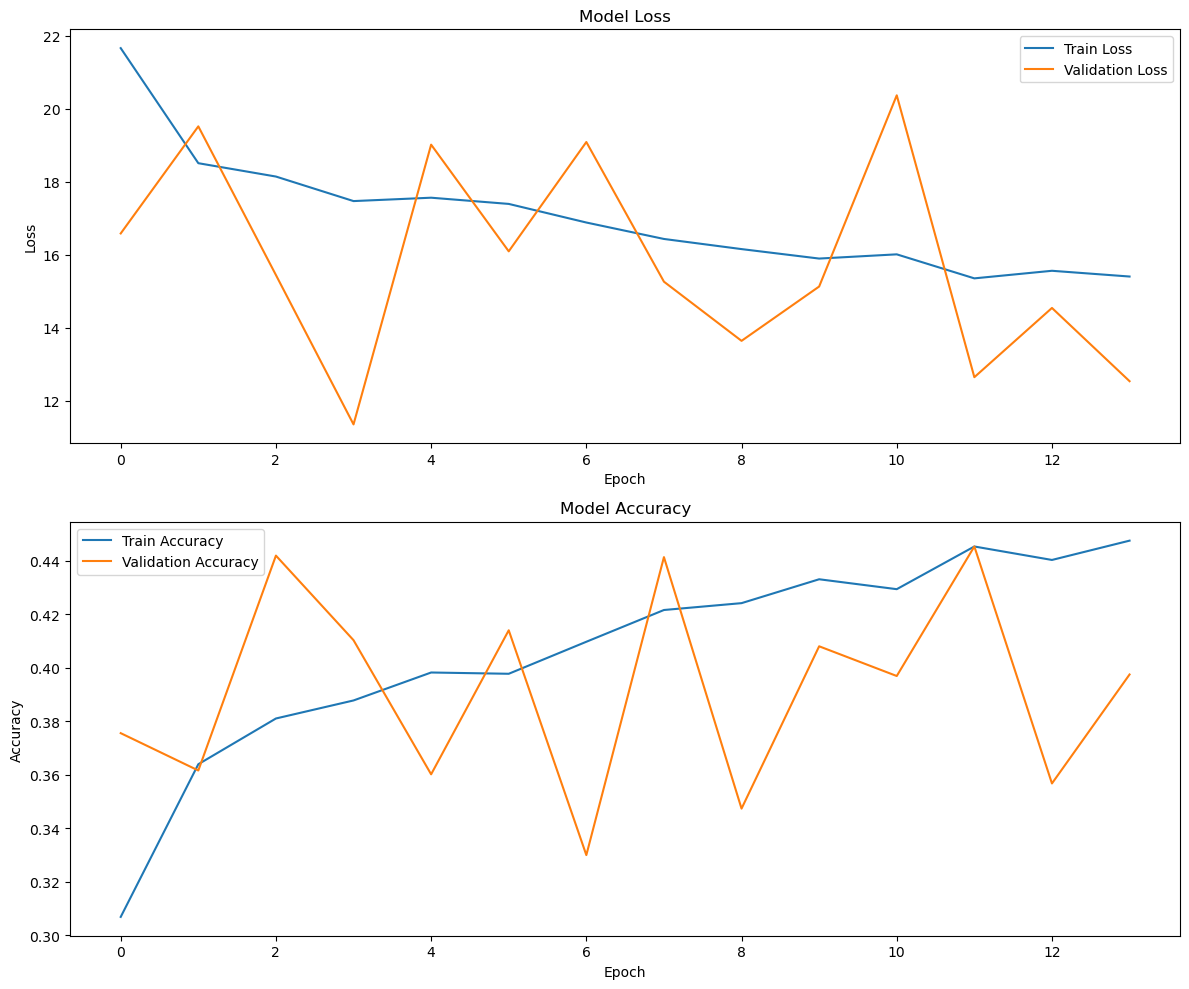

In [34]:
btb_history = trained_btb_model['history']
history_df = pd.DataFrame(btb_history.history)
plot_training(history_df)

## Developing a model that overfits

In [27]:
ML_model = set_up_dnn_model(hidden_layers=1,
                               neurons=32,
                               activation='relu',
                               input_dimension=input_dim,
                               output_dimension=output_class,
                               metrics=multi_metrics,
                               name='Multi_Layer_model')

ML_model.summary()

Model: "Multi_Layer_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 32)                2160032   
                                                                 
 dense_2 (Dense)             (None, 6)                 198       
                                                                 
Total params: 2160230 (8.24 MB)
Trainable params: 2160230 (8.24 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [28]:
trained_ML_model = train_dnn(ML_model,
                             X_train, y_train,
                             X_val, y_val,
                             epochs=300, 
                             callbacks=[])

In [30]:
evaluate_model = trained_ML_model['model'].evaluate(X_val,y_val,verbose=0)
print('Accuracy   : {:.2f}%'.format(evaluate_model[1]*100))
print('Precision  : {:.2f}%'.format(evaluate_model[2]*100))
print('Recall     : {:.2f}%'.format(evaluate_model[3]*100))
print('AUC        : {:.2f}%'.format(evaluate_model[4]*100))

Accuracy   : 45.45%
Precision  : 45.80%
Recall     : 44.74%
AUC        : 71.94%


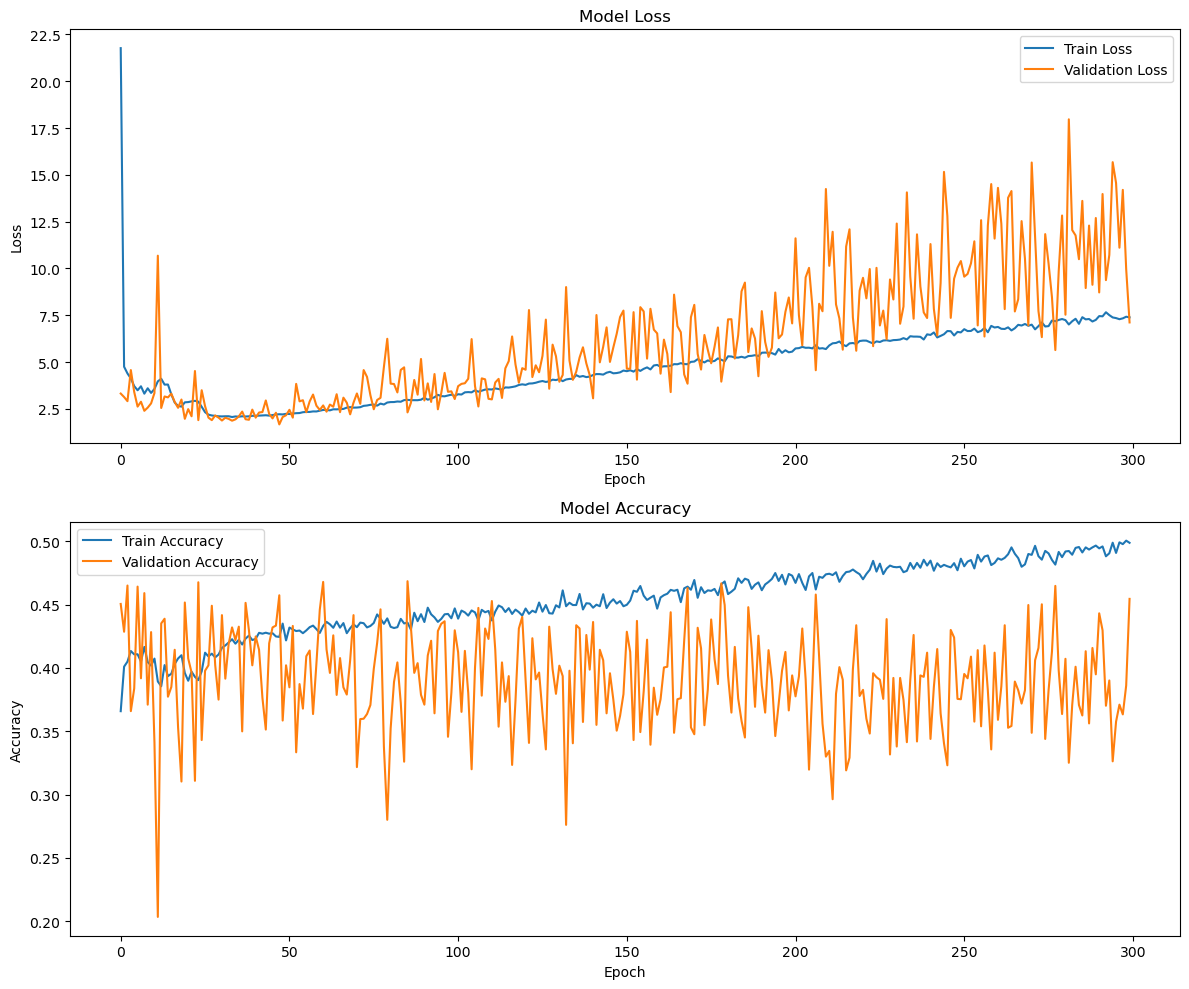

In [31]:
ML_history = trained_ML_model['history']
ML_history_df = pd.DataFrame(ML_history.history)
plot_training(ML_history_df)

### What is overfitting 
Overfitting occurs when the model is fitted exactly against its training data so that it learns the detailed patterns and noise of the training data (IBM, 2023). This leads to negative effects as the performance of the model is poor on new data. Overfitting should be avoided because if a model overfits the training data, it will not generalise well to new data and will have poor predictive performance on data for which it has not been trained on. The goal of machine learning is to build models that have high predictive accuracy for both the training data and the new data, so overfitting defeats the whole purpose

The model above is an example of overfitting. The loss function graph of the model is plotted. From the graph its clear that from 0 to 40 epoch the model is learning from the data as the train loss and validation loss is gradiently decreasing. However after 40th epoch both loss values of train and validation starts to increase indicating the model is no longer learning meaningful patterns from the training data but is instead fitting to the noise or specific characteristics of the training set. Additionally, besides the loss function graph, overfitting can also be identified from the accuracy graph of the model. The general trend shown in the diagram is training accuracy increase steadily over epochs, while the validation accuracy remains within a similar range, resulting in big gap or significant difference of the training accuracy and validation accuracy. This is a typical pattern of overfitting. 

# Regularizing your model and tuning your hyperparameters

### What is Regularization 
Regularization helps prevent machine learning models from overfitting to the training data. As explained above, overfitting occurs when a model learns the details and noise of the training data too well, rather than the underlying trends. This means that it may not generalise well to new data.

Therefore, regularisation is used. Regularisation works by adding a penalty for complexity during model training. This constrains the model and prevents it from adapting too much to the training data. By limiting the complexity of the model, regularisation encourages the model to learn the general patterns in the data rather than memorising every detail.

This allows the model to generalise better to new, unseen data. While regularisation may slightly reduce accuracy on the training data, it typically improves accuracy when evaluating on test data that was not used for training.

Some common regularisation techniques are:

- L1 regularisation - Adds a penalty based on the absolute size of the coefficients. This encourages sparse solutions with fewer parameters.

- L2 regularisation - Adds a penalty based on the squared size of the coefficients. This shrinks the coefficients evenly without encouraging sparsity.

- Early Stopping - Stops training when performance on the validation set is getting worse, typically increase in loss and decreasing in accuracy.

- Dropout - Dropout randomly disables a portion of neurons during training, making sure the model is not overly reliant on specific neurons.

In this project, I used early stopping and dropout techniques to avoid overfitting of the model.

### Hyperparameter tuning 

Hyperparameter tuning is important as it allows maximum performance of the models. By adjusting hyperparameters, such as the number of hidden layers, neurons per layer, activation functions, and dropout rates, could fine-tune the model to achieve its best performance. These hyperparameters control the model's complexity and learning behavior, directly impacting its ability to capture underlying patterns and generalize well to new data.

One approach to hyperparameter tuning involves utilizing Grid search alongside hold-out validation. Hold-out validation involves dividing the data into training and validation sets. In this method of Grid search, for every combination of hyperparameters in the grid, a new model is trained using the specific hyperparameter values on the training set. Subsequently, the model's performance is assessed on the validation set, and the performance metrics are recorded. Through this iterative process can identify the set of hyperparameters that result in the highest accuracy.

In [14]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=0)

parameters= {
'hidden_layers':[1,2],
'neurons': [16, 32 ,64],
'activation': ['relu'],
'dropout': [0.25, 0.5],
}

The grid search_function and get_best is manually written 

In [15]:
# hold-out validation with gridsearch
def grid_search(X_train, y_train, 
                X_val, y_val, 
                parameters, 
                metrics):
    
    """
    Perform grid search over hyperparameters for a deep neural network using hold-out validation.

    parameters:
    train_X  (array): training data
    train_y  (array): labels of the training data
    val_X    (array): validation data
    val_y    (array): labels of the validation data
    parameters(dict):dictionary containing hyperparameters to search over.
    metrics   (list): liist of metrics
    
    returns:
    performance_list (list) :Evaluation scores for each hyperparameter combination.
    
    parameters_list (list) :Hyperparameter values corresponding to each evaluation score.
    """
    performance_list = []
    parameters_list = []
    
    for param_combo in [dict(zip(parameters.keys(), values)) for values in itertools.product(*parameters.values())]: 
        hyp_model = set_up_dnn_model(hidden_layers=param_combo['hidden_layers'],
                                     neurons=param_combo['neurons'],
                                     activation=param_combo['activation'],
                                     dropout=param_combo['dropout'],
                                     input_dimension=X_train.shape[1],
                                     output_dimension=y_train.shape[1],
                                     metrics=metrics)

        trained_model = train_dnn(hyp_model, 
                                  X_train,
                                  y_train, 
                                  X_val,
                                  y_val,
                                  epochs=50,
                                  callbacks=[early_stop])

        evaluations = trained_model['model'].evaluate(X_val, y_val, verbose=0)
        
        performance_list.append(evaluations)
        parameters_list.append(param_combo)
        

    return performance_list, parameters_list


In [16]:
def get_best(performance, parameters):
    """
    Find the best hyperparameter combination based on the evaluation

    parameters:
    performance (list):evaluation scores for each hyperparameter combination
    parameters (list): hyperparameter values corresponding to each evaluation score

    returns: arrays containing the best evaluation score and its corresponding hyperparameter values
    """
    if len(performance) == 0:
        return None, None 
    
    best_performance = performance[0]
    best_parameters = parameters[0]
    
    for i in range(1, len(performance)):  
        if performance[i][1] > best_performance[1]:
            best_performance = performance[i]
            best_parameters = parameters[i]
    
    return best_performance, best_parameters


Grid search is conducted on hyperparameter options, evaluating different combinations to optimize the deep neural network model's performance. After processing, the optimal combination is determined to include two hidden layers, 16 neurons per layer, ReLU activation, and a dropout rate of 0.5. These parameters are chosen based on their performance metrics during validation. With the best hyperparameters identified, the next step involves building the optimal model.

In [22]:
performance, parameters = grid_search(X_train, y_train,
                                      X_val, y_val, 
                                      parameters, multi_metrics)

2024-03-10 02:06:22.021647: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


In [23]:
opt_per,opt_param=get_best(performance, parameters)
print('Best hyperparameters are:', opt_param)
print('The performance:', opt_per)

Best hyperparameters are: {'hidden_layers': 2, 'neurons': 16, 'activation': 'relu', 'dropout': 0.5}
The performance: [1.755135178565979, 0.3585067093372345, 0.5092783570289612, 0.21117126941680908, 0.7362565994262695]


### Building the optimal model (with optimal hyperparameters)

In [25]:
def performance_of_model(y_pred, actual_labels):
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_true_labels = np.argmax(actual_labels, axis=1)
    
    accuracy = metrics.accuracy_score(y_true_labels, y_pred_labels)
    precision = metrics.precision_score(y_true_labels, y_pred_labels, average='macro')
    recall = metrics.recall_score(y_true_labels, y_pred_labels, average='macro')
    auc = metrics.roc_auc_score(actual_labels, y_pred, average='macro')

    print('Accuracy  : {:.2%}'.format(accuracy))
    print('Precision : {:.2%}'.format(precision))
    print('Recall    : {:.2%}'.format(recall))
    print('ROC AUC   : {:.2%}'.format(auc))

    confusion_matrix = metrics.confusion_matrix(y_true_labels, y_pred_labels)
    print('\n Confusion Matrix:')
    print(confusion_matrix)

    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[str(i) for i in range(y_pred.shape[1])], yticklabels=[str(i) for i in range(y_pred.shape[1])])
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

    fpr, tpr, thresholds = metrics.roc_curve(actual_labels.ravel(), y_pred.ravel())
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc='lower right')
    plt.show()


THe optimal model is built with the best hyperparameters found. 

In [68]:
# developing the optimal model 
optimal_model = set_up_dnn_model(hidden_layers=opt_param['hidden_layers'],
                             neurons=opt_param['neurons'],
                             activation=opt_param['activation'],
                             dropout=opt_param['dropout'],
                             input_dimension=X_train.shape[1],
                             output_dimension=y_train.shape[1],
                             metrics=multi_metrics,
                             name='Optimal_model')

optimal_model.summary()

Model: "Optimal_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_27 (Dense)            (None, 16)                1080016   
                                                                 
 dropout_18 (Dropout)        (None, 16)                0         
                                                                 
 dense_28 (Dense)            (None, 16)                272       
                                                                 
 dropout_19 (Dropout)        (None, 16)                0         
                                                                 
 dense_29 (Dense)            (None, 6)                 102       
                                                                 
Total params: 1080390 (4.12 MB)
Trainable params: 1080390 (4.12 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [69]:
stopping= EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=7, verbose=1)

trained_model = train_dnn(optimal_model, 
                  X_train, y_train,  
                  X_val,y_val,
                  batch_size=32,
                  epochs=50,
                  callbacks=[stopping])

Restoring model weights from the end of the best epoch: 14.
Epoch 21: early stopping


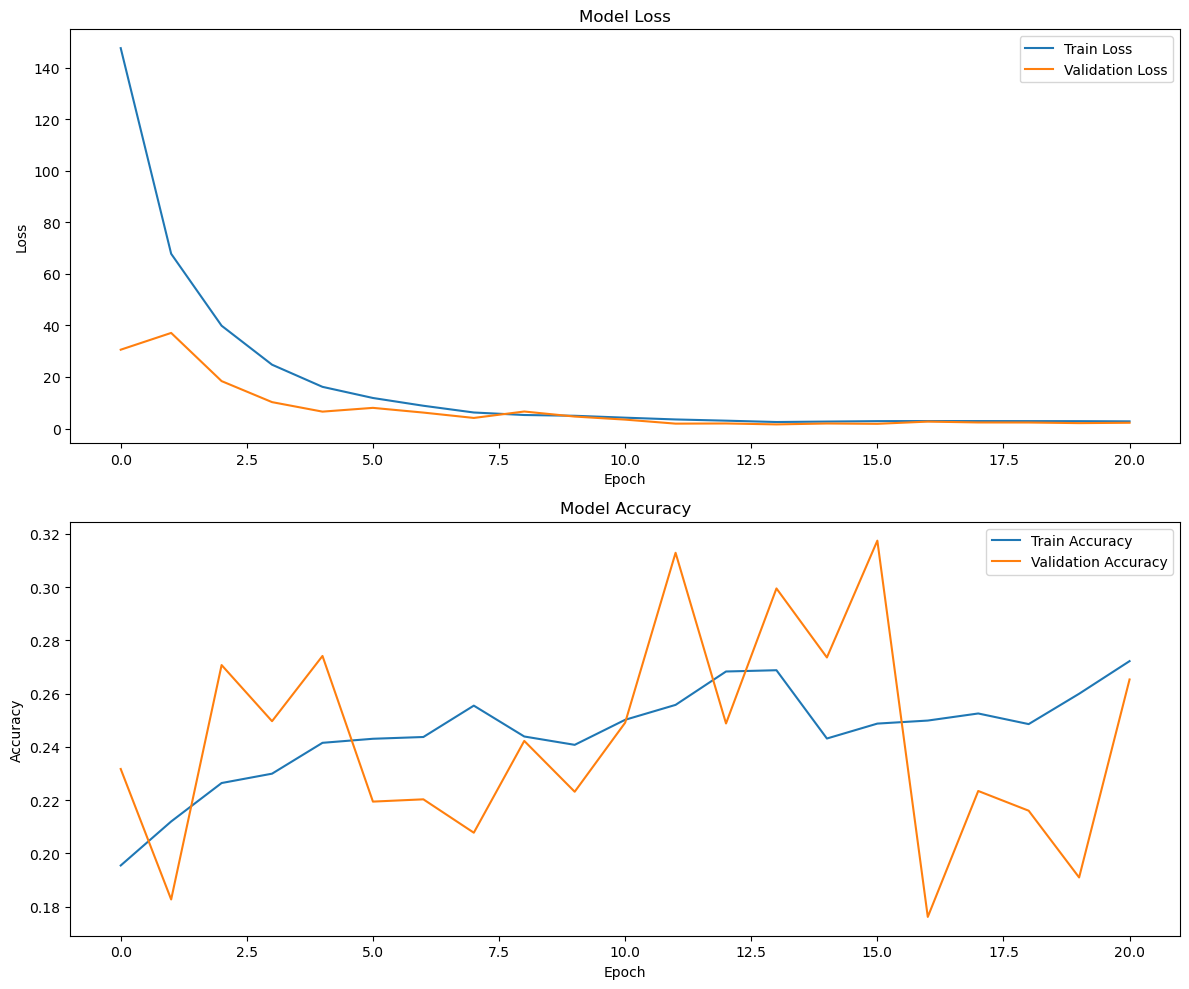

In [70]:
optimal_history = trained_model['history']
history_df = pd.DataFrame(optimal_history.history)
plot_training(history_df)

94/94 [==============================] - 1s 9ms/step
Accuracy  : 30.67%
Precision : 41.84%
Recall    : 29.63%
ROC AUC   : 70.70%

 Confusion Matrix:
[[  2  12 129 289   2   3]
 [  0 221 166  55   2  30]
 [  0   2 226 324   0   1]
 [  0   1  61 458   1   4]
 [  0   7 164 335   0   4]
 [  0  43 311 131   3  13]]


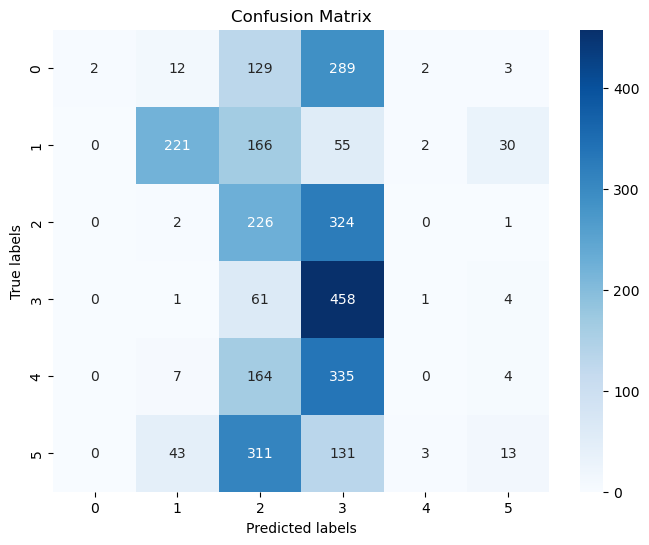

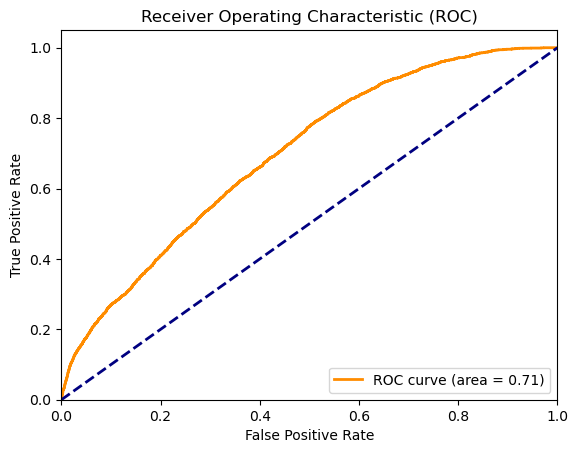

In [71]:
y_pred = trained_model['model'].predict(X_test)
performance_of_model(y_pred, y_test)

## Performance Evaluation: 

The optimal model demonstrates performance on the test set, achieving an accuracy of 30.67%, precision of 41.84%, recall of 29.63%, and an ROC AUC of 70.70%. Despite efforts to prevent overfitting, such as using dropout layers and stopping training with a patience of 8, the model still faces challenges in making accurate predictions. The confusion matrix indicates these difficulties, showing that the model struggles to classify samples correctly across different categories, suggesting its limited ability to distinguish between them.

Although the overall performance of the optimal model is modest, it still surpasses the baseline, indicating a degree of success. Therefore, to improve the model, one approach could involve collecting more data to enhance its training and generalization capabilities. Additionally, employing techniques such as data augmentation to preprocess the image data and make them more suitable for the model could further enhance performance.

## Efforts to Address Overfitting:
Even with two regularization techniques in place, early stopping and dropout, the model still exhibits signs of overfitting. To address this issue, further improvements could be taken to prevent overfitting and improve the model's performance. This may involve configuring the model's architecture, re-fine tunning parameters.

## Exploring different neural network architecture 

In this section, exploring the neural network architectures beyond the initially identified optimal model. By exploring deeper (adding layers) or wider (increasing neuron counts). This is to see if further enhancements in performance can be achieved. 

In [28]:
# Wider model with 256 neuron counts 
wider_model = set_up_dnn_model(hidden_layers=opt_param['hidden_layers'],
                             neurons=256,
                             activation=opt_param['activation'],
                             dropout=opt_param['dropout'],
                             input_dimension=X_train.shape[1],
                             output_dimension=y_train.shape[1],
                             metrics=multi_metrics,
                             name='Wider_model')

wider_model.summary()

Model: "Wider_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 256)               17280256  
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 256)               65792     
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 6)                 1542      
                                                                 
Total params: 17347590 (66.18 MB)
Trainable params: 17347590 (66.18 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [29]:
stopping1= EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=10, verbose=1)

trained_model = train_dnn(wider_model, 
                  X_train, y_train,  
                  X_val,y_val,
                  batch_size=32,
                  epochs=50,
                  callbacks=[stopping1])

Restoring model weights from the end of the best epoch: 2.
Epoch 12: early stopping


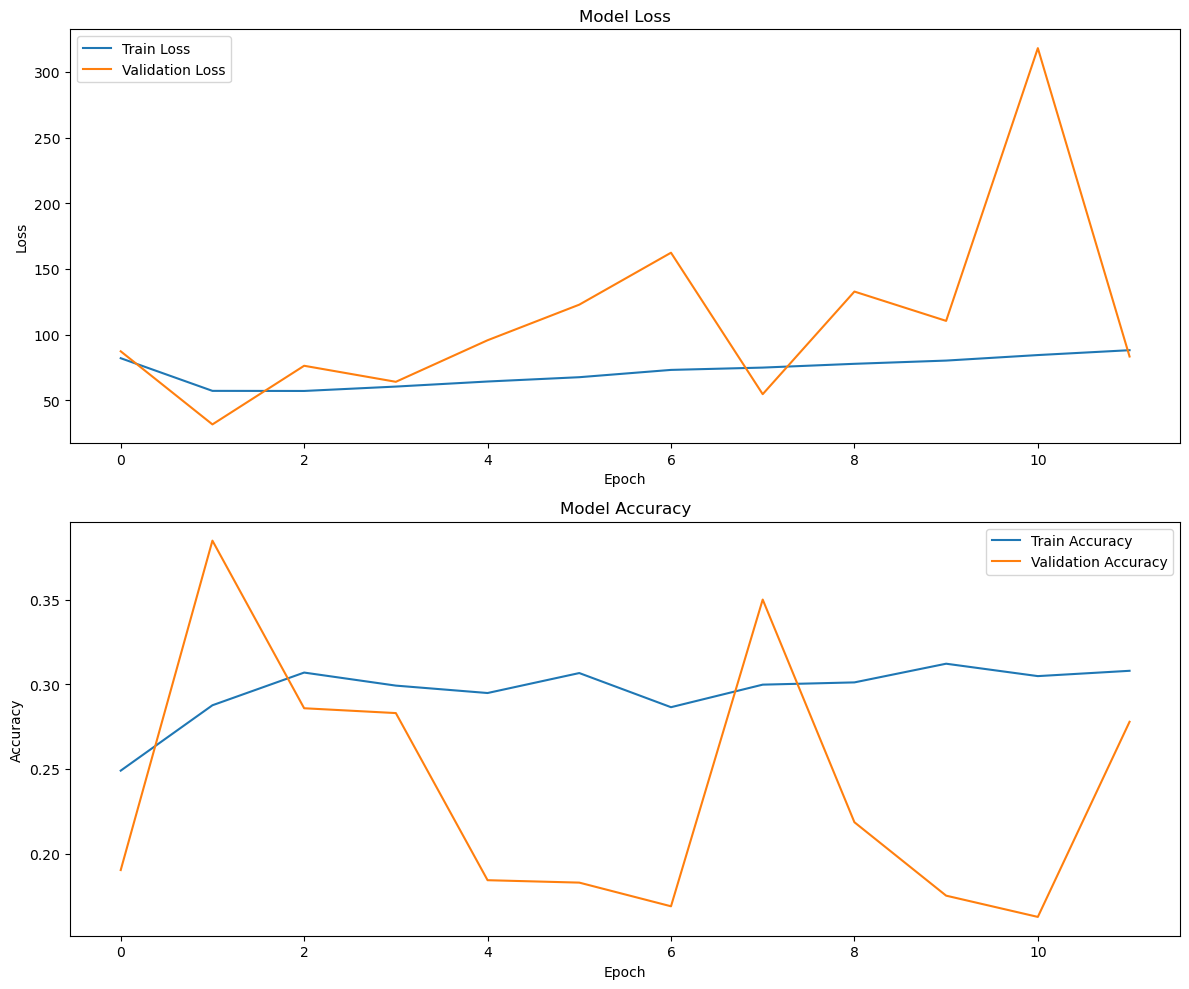

In [30]:
history = trained_model['history']
history_df = pd.DataFrame(history.history)
plot_training(history_df)

94/94 [==============================] - 2s 16ms/step
Accuracy  : 38.50%
Precision : 35.16%
Recall    : 37.39%
ROC AUC   : 73.57%

 Confusion Matrix:
[[  0  98 159 151  28   1]
 [  0 376  53  31  14   0]
 [  0  18 375 128  32   0]
 [  0  52  95 360  18   0]
 [  0  96 237 135  42   0]
 [  0 253 138  81  27   2]]


/Users/julie/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


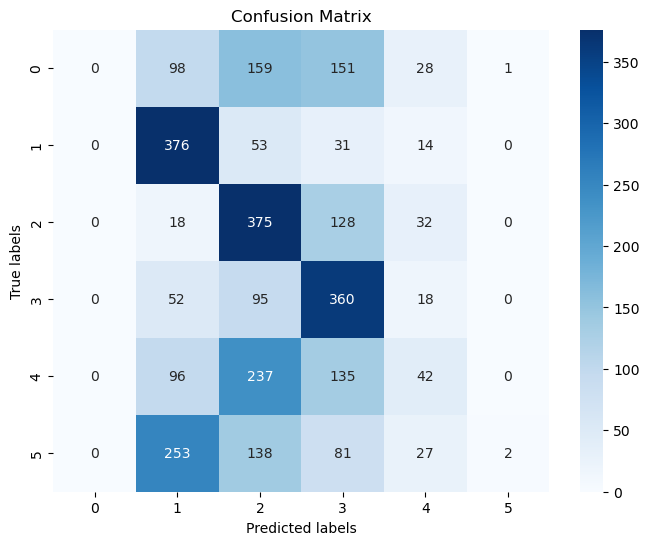

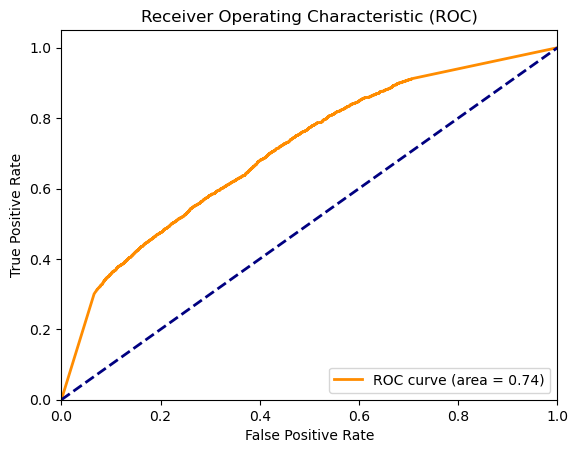

In [32]:
y_pred = trained_model['model'].predict(X_test)
performance_of_model(y_pred, y_test)

THe wider model was constructed with two layers, each consisting of 256 neurons. Subsequently, the model underwent training and evaluation. Upon comparing the performances of the wider neural network model and the optimal model, it became apparent that the wider model showed superior performance.The wider model achieved a higher accuracy rate of 38.50%, compared to the optimal model's 30.67%. Additionally, its recall rate was higher at 37.39%, while the optimal model's recall was 29.63%. Furthermore, the wider model's ROC AUC score of 73.57% suggests its proficiency in distinguishing between different classes within the dataset. These findings underscore the effectiveness of employing a wider architecture in enhancing the overall performance of a neural network model.

In [45]:
#Deeper model with 4 hidden layers 
deeper_model = set_up_dnn_model(hidden_layers=opt_param['hidden_layers'],
                             neurons=opt_param['neurons'],
                             activation=opt_param['activation'],
                             dropout=opt_param['dropout'],
                             input_dimension=X_train.shape[1],
                             output_dimension=y_train.shape[1],
                             metrics=multi_metrics,
                             name='Deeper_model')

deeper_model.summary()

Model: "Deeper_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 16)                1080016   
                                                                 
 dropout_8 (Dropout)         (None, 16)                0         
                                                                 
 dense_13 (Dense)            (None, 16)                272       
                                                                 
 dropout_9 (Dropout)         (None, 16)                0         
                                                                 
 dense_14 (Dense)            (None, 6)                 102       
                                                                 
Total params: 1080390 (4.12 MB)
Trainable params: 1080390 (4.12 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [46]:
stopping2= EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=7, verbose=1)

trained_model = train_dnn(deeper_model, 
                  X_train, y_train,  
                  X_val,y_val,
                  batch_size=32,
                  epochs=50,
                  callbacks=[stopping2])

Restoring model weights from the end of the best epoch: 19.
Epoch 26: early stopping


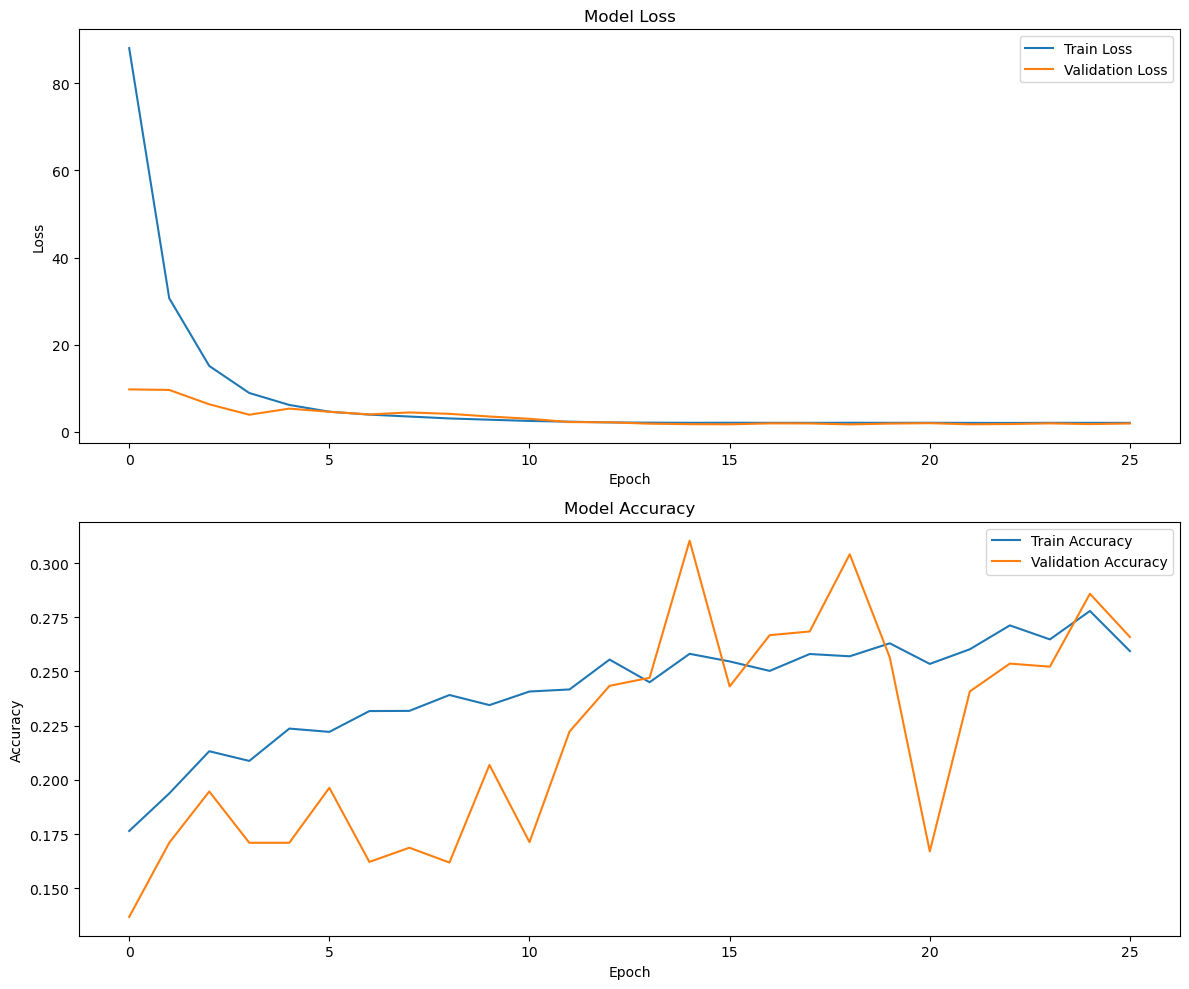

In [47]:
history = trained_model['history']
history_df = pd.DataFrame(history.history)
plot_training(history_df)

94/94 [==============================] - 1s 8ms/step
Accuracy  : 30.63%
Precision : 18.99%
Recall    : 31.10%
ROC AUC   : 72.86%

 Confusion Matrix:
[[  0  57   1   0 339  40]
 [  0 406   1   0  32  35]
 [  0  17   0   0 521  15]
 [  0  28   0   0 454  43]
 [  0  63   3   1 415  28]
 [  0 162   0   0 241  98]]


/Users/julie/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


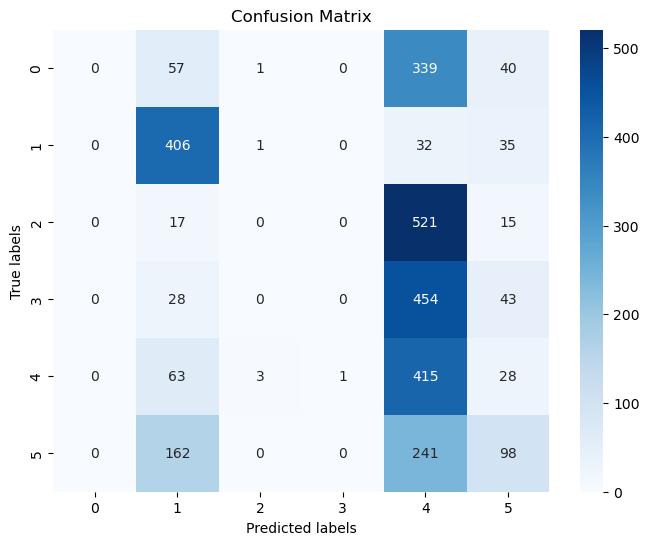

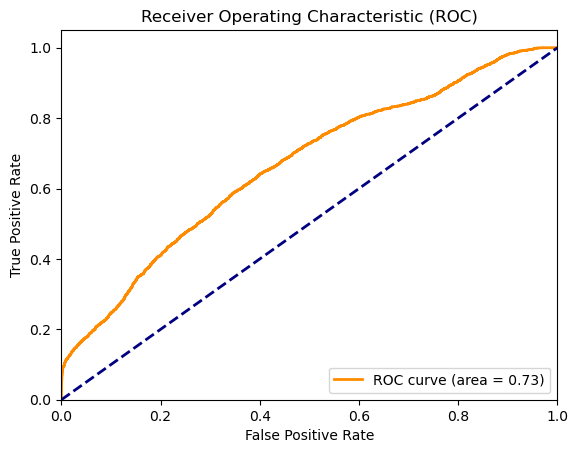

In [48]:
y_pred = trained_model['model'].predict(X_test)
performance_of_model(y_pred, y_test)

The deeper model was constructed with three dense layers, each containing 16 neurons. However, when we compared its performance to the optimal model, it didn't perform as well. Its accuracy was slightly lower at 30.63%, and its precision was much lower at 18.99%. Although its recall was a bit higher at 31.10%, the model still struggled to classify instances correctly across different classes, as indicated by the confusion matrix. Overall, despite its additional complexity, the deeper model did not perofrm better compared to the optimal model.